In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#model processing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

#models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

#evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score, log_loss, matthews_corrcoef

#model deployment
import pickle


Here I will just use logistic regression model in the original dataset

In [2]:
from google.colab import files
uploaded = files.upload()

Saving banksig.csv to banksig.csv


In [0]:
import io
banksig = pd.read_csv(io.BytesIO(uploaded['banksig.csv']))

In [4]:
uploaded = files.upload()

Saving bank-additional-full.csv to bank-additional-full.csv


In [0]:
bank = pd.read_csv(io.BytesIO(uploaded['bank-additional-full.csv']), delimiter = ';')

In [0]:
target = bank['y'].apply(lambda x: 1 if x == 'yes' else 0)

According to our previous observation, I decided to use logistic model that has been tuned based on several hyperparameter. The F1 score and recall are better than without tuning. However, there is still room to improve. We can also use logistic analysis to describe the features -- to observe which one(s) is more likely to increase the likelihood to be in Target Yes, and which one(s) to decrease it. We can also see which features that the model considered as not significant.

In [0]:
# Initiate the model
log_reg = LogisticRegression(solver = 'saga', penalty = 'l1', class_weight = 'balanced', max_iter = 1500, C = 1)

In [0]:
# Splitting the train and test set
X_train, X_test, y_train, y_test = train_test_split(banksig, target, test_size = 0.3, random_state = 101)

In [0]:
# Scaling the X_train and transforming the X_test -- these are the ones we will use
scaler = StandardScaler()

X_trainscale = scaler.fit_transform(X_train)
X_testscale = scaler.transform(X_test)

In [11]:
# Before fitting the model, let's see the coefficients and the significance of our features, based on the train set

import statsmodels.api as sm

logit_model = sm.Logit(y_train, sm.add_constant(X_train))
result = logit_model.fit(method = 'bfgs', maxiter = 1000)
print(result.summary2())

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.284240
         Iterations: 254
         Function evaluations: 261
         Gradient evaluations: 261
                                    Results: Logit
Model:                     Logit                   Pseudo R-squared:        0.195     
Dependent Variable:        y                       AIC:                     16451.8402
Date:                      2020-03-30 03:10        BIC:                     16708.1856
No. Observations:          28831                   Log-Likelihood:          -8194.9   
Df Model:                  30                      LL-Null:                 -10176.   
Df Residuals:              28800                   LLR p-value:             0.0000    
Converged:                 1.0000                  Scale:                   1.0000    
--------------------------------------------------------------------------------------
                             Coef.    Std.Err.     z     P>|z|     [0.025     

In [12]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                28831
Model:                          Logit   Df Residuals:                    28800
Method:                           MLE   Df Model:                           30
Date:                Mon, 30 Mar 2020   Pseudo R-squ.:                  0.1947
Time:                        03:20:31   Log-Likelihood:                -8194.9
converged:                       True   LL-Null:                       -10176.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         -45.4012   1.76e+04     -0.003      0.998   -3.45e+04    3.44e+04
job_admin.                      0.0266      0.055      0.483      0.629      -0.

Here we can see, across 31 features, only 15 features are significant for describing the likelihood to be in Target Yes -- 8 are positive influence, while other 7 are negative influence.

> Significance:
(p-val < 0.05) :

> Positive features and the coefficients
- job_retired (0.3437)
- job_student (0.2830)
- month_dec (0.4318)
- month_jul (0.2350)
- month_mar (1.0068)
- previous (0.1109)
- cons.price.idx (0.6554)
- cons.conf.idx (0.0511)

> Negative features and the coefficients
- job_blue-collar (-0.1488)
- job_services (-0.2021)
- month_sep (-0.2631)
- month_may (-0.6966)
- day_of_week_mon (-0.2414)
- campaign (-0.0590)
- euribor3m (-0.6082)

One thing I like in logistic regression is the ability to help us see what features helps to increase/decrease the likelihood of Target Yes. The ones with positive coefficients here help us to describe that it increase to possibility to be in Target Yes. For example here, being student and retired are more likely to accept the offer from the bank campaign -- so we know that these are the preferred target consumer. On the other hand, people who work blue-collar job or in services sector are less likely to be in Target Yes. We also see that contact in March is more likely for customer to be accept this offer, in contrast is May. So it is better to advise to bank manager to call customers in March rather than in May.

Now we will try to re-fit our model with the only significant features

In [13]:
logitsig = banksig[['job_retired', 'job_student','month_dec', 'month_jul', 'month_mar', 'previous', 'cons.price.idx', 'cons.conf.idx',
'job_blue-collar', 'job_services', 'month_sep', 'month_may','day_of_week_mon', 'campaign', 'euribor3m']]

ERROR! Session/line number was not unique in database. History logging moved to new session 59


In [14]:
logitsig

,job_retired,job_student,month_dec,month_jul,month_mar,previous,cons.price.idx,cons.conf.idx,job_blue-collar,job_services,month_sep,month_may,day_of_week_mon,campaign,euribor3m
0,0,0,0,0,0,0,93.994,-36.4,0,0,0,1,1,1,4.857
1,0,0,0,0,0,0,93.994,-36.4,0,1,0,1,1,1,4.857
2,0,0,0,0,0,0,93.994,-36.4,0,1,0,1,1,1,4.857
3,0,0,0,0,0,0,93.994,-36.4,0,0,0,1,1,1,4.857
4,0,0,0,0,0,0,93.994,-36.4,0,1,0,1,1,1,4.857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,1,0,0,0,0,0,94.767,-50.8,0,0,0,0,0,1,1.028
41184,0,0,0,0,0,0,94.767,-50.8,1,0,0,0,0,1,1.028
41185,1,0,0,0,0,0,94.767,-50.8,0,0,0,0,0,2,1.028
41186,0,0,0,0,0,0,94.767,-50.8,0,0,0,0,0,1,1.028


## Trial 1 --  using only the significant features based on sm Logit

In [0]:
## TRIAL 1 -- splitting the dataset (without scaling)

Xtr_try1, Xts_try1, ytr_try1, yts_try1 = train_test_split(logitsig, target, test_size = 0.3, random_state = 101)

In [16]:
## Fitting the model

log_reg.fit(Xtr_try1, ytr_try1)

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
tr_try1_pred = log_reg.predict(Xtr_try1)

In [18]:
f1_score(ytr_try1, tr_try1_pred)

0.42190016103059585

In [19]:
print(confusion_matrix(ytr_try1, tr_try1_pred))

[[20991  4579]
 [ 1165  2096]]


In [0]:
ts_try1_pred = log_reg.predict(Xts_try1)

In [21]:
f1_score(yts_try1, ts_try1_pred)

0.4132947976878613

In [22]:
print(confusion_matrix(yts_try1, ts_try1_pred))

[[9063 1915]
 [ 521  858]]


In [23]:
print(classification_report(yts_try1, ts_try1_pred))

              precision    recall  f1-score   support

           0       0.95      0.83      0.88     10978
           1       0.31      0.62      0.41      1379

    accuracy                           0.80     12357
   macro avg       0.63      0.72      0.65     12357
weighted avg       0.87      0.80      0.83     12357



Here we see a slight improvement from our model, the number of True positives increased to 858 (earlier with all features are only 833). The recall also increased, however the f1 score stays the same (but at least I did not get error without scaling) -- now let's move on with scaling

In [0]:
Xtr_try1scale = scaler.fit_transform(Xtr_try1)

In [0]:
Xts_try1scale = scaler.transform(Xts_try1)

In [50]:
log_reg.fit(Xtr_try1scale, ytr_try1)

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
tr_try1_predscale = log_reg.predict(Xtr_try1scale)

In [53]:
f1_score(ytr_try1, tr_try1_predscale)

0.4404292597459483

In [58]:
print(classification_report(ytr_try1, tr_try1_predscale))

              precision    recall  f1-score   support

           0       0.95      0.85      0.89     25570
           1       0.34      0.62      0.44      3261

    accuracy                           0.82     28831
   macro avg       0.64      0.73      0.67     28831
weighted avg       0.88      0.82      0.84     28831



In [0]:
ts_try1_predscale = log_reg.predict(Xts_try1scale)

In [55]:
f1_score(yts_try1, ts_try1_predscale)

0.4304130491975796

In [56]:
print(classification_report(yts_try1, ts_try1_predscale))

              precision    recall  f1-score   support

           0       0.94      0.85      0.90     10978
           1       0.34      0.59      0.43      1379

    accuracy                           0.82     12357
   macro avg       0.64      0.72      0.66     12357
weighted avg       0.88      0.82      0.84     12357



In [57]:
print(confusion_matrix(yts_try1, ts_try1_predscale))

[[9374 1604]
 [ 561  818]]


Using the scaling data improved our F1 score -- it actually tried to balance the precision and recall, by improving the precision score. We can see that the model can predict True negatives more than misclassify them. However the number of True Positives decreased 40 observations.

## Trial 2
Since logistic regression is sensitive with outliers, now I am thinking of removing the outliers from numerical features -- first I will try cons.price.idx. Based on EDA we did before (I assume mainly caused by class imbalance), we found out that it is not normally distributed. Thus I will  remove the outliers based on median/IQR method.

In [0]:
##find the outlier
Q1_amd = banksig['cons.price.idx'].describe()['25%']
Q3_amd = banksig['cons.price.idx'].describe()['75%']
IQR = Q3_amd - Q1_amd

#yang bukan outlier
nout_amd = banksig[(banksig['cons.price.idx'] >= Q1_amd - (1.5*IQR)) & (banksig['cons.price.idx'] <= Q3_amd + (1.5 * IQR))]['cons.price.idx'].index

#yang outlier
# out_amd = banksig[(banksig['age'] < Q1_amd - (1.5*IQR)) | (banksig['age'] > Q3_amd + (1.5 * IQR))]['age'].index

In [0]:
bank_nooutliers1 = banksig.loc[nout_amd]

In [33]:
# Turns out we don't have outliers in here
bank_nooutliers1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41188 entries, 0 to 41187
Data columns (total 31 columns):
job_admin.                     41188 non-null int64
job_blue-collar                41188 non-null int64
job_entrepreneur               41188 non-null int64
job_retired                    41188 non-null int64
job_services                   41188 non-null int64
job_student                    41188 non-null int64
job_unemployed                 41188 non-null int64
marital_married                41188 non-null int64
marital_single                 41188 non-null int64
education_basic                41188 non-null int64
education_university.degree    41188 non-null int64
education_unknown              41188 non-null int64
default_no                     41188 non-null int64
default_unknown                41188 non-null int64
contact_cellular               41188 non-null int64
contact_telephone              41188 non-null int64
month_apr                      41188 non-null int64
month_d

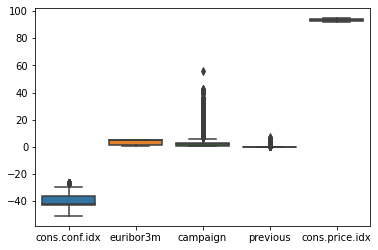

In [36]:
# Let's check the other features using boxplot

sns.boxplot(data = banksig[['cons.conf.idx', 'euribor3m', 'campaign', 'previous', 'cons.price.idx']])

In [0]:
# The one which have a lot of outliers is campaign, so let's remove this one
##find the outlier
Q1_camp = banksig['campaign'].describe()['25%']
Q3_camp = banksig['campaign'].describe()['75%']
IQRc = Q3_camp - Q1_camp

#yang bukan outlier
nout_camp = banksig[(banksig['campaign'] >= Q1_camp - (1.5*IQR)) & (banksig['campaign'] <= Q3_camp + (1.5 * IQR))]['campaign'].index

In [0]:
bank_nooutliers2 = banksig.loc[nout_camp]

In [45]:
# we removed approximately 6000 rows. let's check whether using this data set will improve our prediction
bank_nooutliers2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36204 entries, 0 to 41187
Data columns (total 31 columns):
job_admin.                     36204 non-null int64
job_blue-collar                36204 non-null int64
job_entrepreneur               36204 non-null int64
job_retired                    36204 non-null int64
job_services                   36204 non-null int64
job_student                    36204 non-null int64
job_unemployed                 36204 non-null int64
marital_married                36204 non-null int64
marital_single                 36204 non-null int64
education_basic                36204 non-null int64
education_university.degree    36204 non-null int64
education_unknown              36204 non-null int64
default_no                     36204 non-null int64
default_unknown                36204 non-null int64
contact_cellular               36204 non-null int64
contact_telephone              36204 non-null int64
month_apr                      36204 non-null int64
month_d

In [0]:
target_try2 = target.loc[nout_camp]

In [0]:
Xtr_try2, Xts_try2, ytr_try2, yts_try2 = train_test_split(bank_nooutliers2, target_try2, test_size = 0.3, random_state = 101)

In [61]:
# Try without scaling
log_reg.fit(Xtr_try2, ytr_try2)

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
tr_try2_pred = log_reg.predict(Xtr_try2)

In [64]:
f1_score(ytr_try2, tr_try2_pred)

0.42368729364149543

In [65]:
print(classification_report(ytr_try2, tr_try2_pred))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87     22371
           1       0.31      0.67      0.42      2971

    accuracy                           0.79     25342
   macro avg       0.63      0.74      0.65     25342
weighted avg       0.87      0.79      0.82     25342



In [0]:
ts_try2_pred = log_reg.predict(Xts_try2)

In [67]:
f1_score(yts_try2, ts_try2_pred)

0.425376762275158

In [68]:
print(classification_report(yts_try2, ts_try2_pred))

              precision    recall  f1-score   support

           0       0.94      0.80      0.87      9499
           1       0.32      0.64      0.43      1363

    accuracy                           0.78     10862
   macro avg       0.63      0.72      0.65     10862
weighted avg       0.86      0.78      0.81     10862



In [69]:
print(confusion_matrix(yts_try2, ts_try2_pred))

[[7623 1876]
 [ 488  875]]


Here we see a great improvement towards predicting the True Positives. However there is also a trade-off, more misclassification of Target No.

In [0]:
# let's try using the scaling one

Xtr_try2scale = scaler.fit_transform(Xtr_try2)
Xts_try2scale = scaler.transform(Xts_try2)

In [71]:
# fitting the model
log_reg.fit(Xtr_try2scale, ytr_try2)

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
tr_try2_predscale = log_reg.predict(Xtr_try2scale)

In [73]:
f1_score(ytr_try2, tr_try2_predscale)

0.4398555630783119

In [74]:
print(classification_report(ytr_try2, tr_try2_predscale))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88     22371
           1       0.33      0.66      0.44      2971

    accuracy                           0.80     25342
   macro avg       0.64      0.74      0.66     25342
weighted avg       0.88      0.80      0.83     25342



In [0]:
ts_try2_predscale = log_reg.predict(Xts_try2scale)

In [76]:
f1_score(yts_try2, ts_try2_predscale)

0.4405648267008986

In [77]:
print(classification_report(yts_try2, ts_try2_predscale))

              precision    recall  f1-score   support

           0       0.94      0.82      0.88      9499
           1       0.34      0.63      0.44      1363

    accuracy                           0.80     10862
   macro avg       0.64      0.73      0.66     10862
weighted avg       0.86      0.80      0.82     10862



In [78]:
print(confusion_matrix(yts_try2, ts_try2_predscale))

[[7825 1674]
 [ 505  858]]


We actually did not see a great improvement here using the scaled data (surprisingly our original data is better -- although we need to see the stability of the model first)

## Trial 3 -- Introducing threshold
This is the last strategy I will try in here. We already put a balanced weight for both classes by using the method in logistic regression model, first I will try using threshold instead of modifying the weight.

In [79]:
## Back to the original dataset
# Actually now I am curious what if we just fit to unscaled data -- but I must admit that fitting to the scaled data is faster
# I got a convergence warning though, I am afraid actually it did not converge --  so just go back to the scaled one
log_reg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [80]:
# much faster in fitting
log_reg.fit(X_trainscale, y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [81]:
PredictProb = log_reg.predict_proba(X_testscale)
PredictProb

array([[0.81156501, 0.18843499],
       [0.70933899, 0.29066101],
       [0.78252392, 0.21747608],
       ...,
       [0.61975384, 0.38024616],
       [0.68362271, 0.31637729],
       [0.70717324, 0.29282676]])

In [0]:
# since I assume in the default model they used 0.5 threshold, now let's try using a higher probability 
# threshold for Target No predictions

prediction = []
for pred in PredictProb[:,0]:
    if (pred > 0.70):
        prediction.append(0)
    else:
        prediction.append(1)


In [83]:
# now let's see if we make any difference
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.96      0.41      0.57     10978
           1       0.16      0.87      0.26      1379

    accuracy                           0.46     12357
   macro avg       0.56      0.64      0.42     12357
weighted avg       0.87      0.46      0.54     12357



In [84]:
print(confusion_matrix(y_test,prediction))

[[4478 6500]
 [ 186 1193]]


Okay probably this is too much. Let's try to lower down our threshold

In [0]:
prediction2 = []
for pred in PredictProb[:,0]:
    if (pred > 0.6):
        prediction2.append(0)
    else:
        prediction2.append(1)

In [86]:
print(confusion_matrix(y_test,prediction2))

[[7907 3071]
 [ 401  978]]


In [87]:
print(classification_report(y_test,prediction2))

              precision    recall  f1-score   support

           0       0.95      0.72      0.82     10978
           1       0.24      0.71      0.36      1379

    accuracy                           0.72     12357
   macro avg       0.60      0.71      0.59     12357
weighted avg       0.87      0.72      0.77     12357



Here we see that introducing the threshold improved our recall score, but our f1 and precision scores are really poor. We adjusted the model to predict more Target Yes, but in a cost of misclassifying the Target No (it's a quite significant number and also resources the bank needs to expend)

Now let's see what happen if we modify the class weight

Specifically, the balanced argument will automatically weigh classes inversely proportional to their frequency:

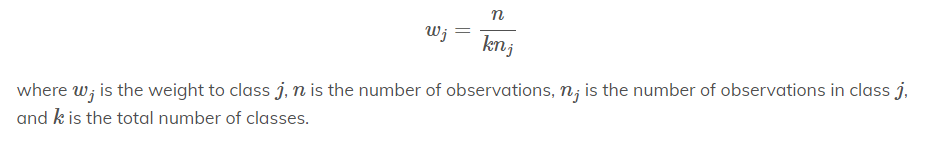

In [94]:
# first let's see our class weight
from sklearn.utils.class_weight import compute_class_weight

# calculate class weighting
weighting = compute_class_weight('balanced', [0,1], y_train)
weighting

array([0.56376613, 4.42057651])

Here we see that our class weight is quite extreme already, the weight of Target No is only 0.5, while the weight for Target Yes is 8 times bigger. 
Let's try if we modify the class weight so it will be heavier for our Target Yes.

In [0]:
## let's put our class weight for Target Yes as 5
# redefine our model

log_reg2 = LogisticRegression(solver = 'saga', penalty = 'l1', class_weight = {0 : 0.5, 1 : 5}, max_iter = 1500, C = 1)

In [96]:
log_reg2.fit(X_trainscale, y_train)

LogisticRegression(C=1, class_weight={0: 0.5, 1: 5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1500, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [97]:
f1_score(y_train, log_reg2.predict(X_trainscale))

0.3938257608790442

In [98]:
print(classification_report(y_train, log_reg2.predict(X_trainscale)))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85     25570
           1       0.28      0.69      0.39      3261

    accuracy                           0.76     28831
   macro avg       0.61      0.73      0.62     28831
weighted avg       0.87      0.76      0.80     28831



In [99]:
print(confusion_matrix(y_train, log_reg2.predict(X_trainscale)))

[[19622  5948]
 [ 1003  2258]]


In [0]:
weight_test = log_reg2.predict(X_testscale)

In [101]:
print(classification_report(y_test, weight_test))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85     10978
           1       0.27      0.67      0.39      1379

    accuracy                           0.76     12357
   macro avg       0.61      0.72      0.62     12357
weighted avg       0.87      0.76      0.80     12357



In [102]:
print(confusion_matrix(y_test, weight_test))

[[8481 2497]
 [ 453  926]]


We see an improvement in predicting the Target Yes, but as before, the misclassification of Target No is increasing. The percentage of Target Yes prediction is about 67%, compared to Target No 77%.

## Trial 4 -- using information we got from all other trials.
Here I will first remove the campaign outlier (trial 2), then use only the significant features (trial 1), and comparing the class weight (balanced and self-set)

In [0]:
## back to trial 2

In [105]:
bank_nooutliers2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36204 entries, 0 to 41187
Data columns (total 31 columns):
job_admin.                     36204 non-null int64
job_blue-collar                36204 non-null int64
job_entrepreneur               36204 non-null int64
job_retired                    36204 non-null int64
job_services                   36204 non-null int64
job_student                    36204 non-null int64
job_unemployed                 36204 non-null int64
marital_married                36204 non-null int64
marital_single                 36204 non-null int64
education_basic                36204 non-null int64
education_university.degree    36204 non-null int64
education_unknown              36204 non-null int64
default_no                     36204 non-null int64
default_unknown                36204 non-null int64
contact_cellular               36204 non-null int64
contact_telephone              36204 non-null int64
month_apr                      36204 non-null int64
month_d

In [0]:
logitsig2 = bank_nooutliers2[['job_retired', 'job_student','month_dec', 'month_jul', 'month_mar', 'previous', 'cons.price.idx', 'cons.conf.idx',
'job_blue-collar', 'job_services', 'month_sep', 'month_may','day_of_week_mon', 'campaign', 'euribor3m']]

In [0]:
#Splitting the dataset

Xtr_try4, Xts_try4, ytr_try4, yts_try4 = train_test_split(logitsig2, target_try2, test_size = 0.3, random_state = 101)


In [0]:
# balanced logreg
# scaling the X

Xtr_try4scale = scaler.fit_transform(Xtr_try4)
Xts_try4scale = scaler.transform(Xts_try4)

In [110]:
log_reg.fit(Xtr_try4scale, ytr_try4)

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
tr_try4_pred = log_reg.predict(Xtr_try4scale)

In [112]:
f1_score(ytr_try4, tr_try4_pred)

0.44517569632154186

In [0]:
ts_try4_pred = log_reg.predict(Xts_try4scale)

In [114]:
f1_score(yts_try4, ts_try4_pred)

0.45005370569280345

In [115]:
print(classification_report(yts_try4, ts_try4_pred))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89      9499
           1       0.35      0.61      0.45      1363

    accuracy                           0.81     10862
   macro avg       0.65      0.73      0.67     10862
weighted avg       0.87      0.81      0.83     10862



In [116]:
print(confusion_matrix(yts_try4, ts_try4_pred))

[[7976 1523]
 [ 525  838]]


In [118]:
## The self-set class weight

log_reg2.fit(Xtr_try4scale, ytr_try4)

LogisticRegression(C=1, class_weight={0: 0.5, 1: 5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1500, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [119]:
f1_score(ytr_try4, log_reg2.predict(Xtr_try4scale))

0.3830783078307831

In [0]:
ts_try4_pred2 = log_reg2.predict(Xts_try4scale)

In [121]:
print(confusion_matrix(yts_try4, ts_try4_pred2))

[[6971 2528]
 [ 422  941]]


In [122]:
print(classification_report(yts_try4, ts_try4_pred2))

              precision    recall  f1-score   support

           0       0.94      0.73      0.83      9499
           1       0.27      0.69      0.39      1363

    accuracy                           0.73     10862
   macro avg       0.61      0.71      0.61     10862
weighted avg       0.86      0.73      0.77     10862



Here we see an improvement of the recall score in the self-set class weight. We also increased around 100 Target Yes, but it should be noted that we also increase the False Positive by 1000. 

Personally while I prefer to have more True Positive cases, but I think considering how much bank will lose is also important -- thus for now on I will use the balanced weight.

In [0]:
# let's see once again the feature coefficients here

In [123]:
logit_model2 = sm.Logit(ytr_try4, sm.add_constant(Xtr_try4))
result = logit_model2.fit(method = 'bfgs', maxiter = 1000)
print(result.summary2())

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.291223
         Iterations: 135
         Function evaluations: 140
         Gradient evaluations: 140
                          Results: Logit
Model:                Logit            Pseudo R-squared: 0.194     
Dependent Variable:   y                AIC:              14792.3246
Date:                 2020-03-30 06:08 BIC:              14922.5681
No. Observations:     25342            Log-Likelihood:   -7380.2   
Df Model:             15               LL-Null:          -9158.1   
Df Residuals:         25326            LLR p-value:      0.0000    
Converged:            1.0000           Scale:            1.0000    
-------------------------------------------------------------------
                 Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
-------------------------------------------------------------------
const           -42.1177   3.9679 -10.6145 0.0000 -49.8947 -34.3407
job_retired       0.3006   0.0841   

Here we saw that all the features are significant, except for campaign and month_sep. Let's check our model once again (balanced weight) by omitting those two features.

In [0]:
logitsig3 = bank_nooutliers2[['job_retired', 'job_student','month_dec', 'month_jul', 'month_mar', 'previous', 'cons.price.idx', 'cons.conf.idx',
'job_blue-collar', 'job_services', 'month_may','day_of_week_mon', 'euribor3m']]

In [0]:
#Splitting the dataset

Xtr_try5, Xts_try5, ytr_try5, yts_try5 = train_test_split(logitsig3, target_try2, test_size = 0.3, random_state = 101)


In [0]:
#Scaling the Xs

Xtr_try5scale = scaler.fit_transform(Xtr_try5)
Xts_try5scale = scaler.transform(Xts_try5)

In [128]:
## fitting the balanced model

log_reg.fit(Xtr_try5scale, ytr_try5)

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [129]:
f1_score(ytr_try5, log_reg.predict(Xtr_try5scale))

0.4454117647058824

In [0]:
ts_try5_pred = log_reg.predict(Xts_try5scale)

In [131]:
f1_score(yts_try5, ts_try5_pred)

0.449384038564542

In [132]:
print(confusion_matrix(yts_try5, ts_try5_pred))

[[7967 1532]
 [ 524  839]]


In [133]:
print(classification_report(yts_try5, ts_try5_pred))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89      9499
           1       0.35      0.62      0.45      1363

    accuracy                           0.81     10862
   macro avg       0.65      0.73      0.67     10862
weighted avg       0.86      0.81      0.83     10862



After we removed the features it does not seem to improve our model. We only increase the prediction of Target Yes by one, but misclassify 9 of True Negative. Let's stick with the one before this.

## Checking model stability

For this part, we will use the :
* original logistic regression model with a balanced class weight
* the dataset with the removed campaign outliers and 15 significant features from the original sm.Logit

In [0]:
# The model
log_reg = LogisticRegression(solver = 'saga', penalty = 'l1', class_weight = 'balanced', max_iter = 1500, C = 1)

In [0]:
# The dataset
logitsig2 = bank_nooutliers2[['job_retired', 'job_student','month_dec', 'month_jul', 'month_mar', 'previous', 'cons.price.idx', 'cons.conf.idx',
'job_blue-collar', 'job_services', 'month_sep', 'month_may','day_of_week_mon', 'campaign', 'euribor3m']]

In [0]:
#Splitting the dataset

Xtr_fin, Xts_fin, ytr_fin, yts_fin = train_test_split(logitsig2, target_try2, test_size = 0.3, random_state = 101)


In [0]:
# Making metrics functions first

def calc_train_error(X_train, y_train, model):
    predictions = model.predict(X_train)
    predictProba = model.predict_proba(X_train)
    matt = matthews_corrcoef(y_train, predictions)
    f1 = f1_score(y_train, predictions)
    report = classification_report(y_train, predictions)
    roc_auc = roc_auc_score(y_train, predictProba[:,1])
    accuracy = accuracy_score(y_train, predictions)
    confmatrix = confusion_matrix(y_train, predictions)
    logloss = log_loss(y_train, predictProba)
    return {
        'report': report,
        'matthew':matt,
        'f1': f1,
        'roc': roc_auc,
        'accuracy': accuracy,
        'confusion': confmatrix,
        'logloss': logloss
    }
  
def calc_validation_error(X_test, y_test, model):
    predictions = model.predict(X_test)
    predictProba = model.predict_proba(X_test)
    matt = matthews_corrcoef(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    roc_auc = roc_auc_score(y_test, predictProba[:,1])
    accuracy = accuracy_score(y_test, predictions)
    confmatrix = confusion_matrix(y_test, predictions)
    logloss = log_loss(y_test, predictProba)
    return {
        'report': report,
        'matthew':matt,
        'f1': f1,
        'roc': roc_auc,
        'accuracy': accuracy,
        'confusion': confmatrix,
        'logloss': logloss
    }

def calc_metrics(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

## KFold

In [0]:
# For Logistic Regression
k = 5
kf_log = KFold(n_splits = k, shuffle = True, random_state = 101)

In [0]:
train_errors = []
valid_errors = []

for train_index, val_index in kf_log.split(logitsig2,target_try2):
    
    #split data
    X_trn, X_val = logitsig2.iloc[train_index], logitsig2.iloc[val_index]
    y_trn, y_val = target_try2.iloc[train_index], target_try2.iloc[val_index]
    
    #instantiate model -- taking the one with the best hyperparameter according to the randomsearch
    log_reg = LogisticRegression(solver = 'saga', penalty = 'l1', class_weight = 'balanced', max_iter = 1500, C = 1)

    #Scaling our X_train_log and X_val_log
    X_tr_scale = scaler.fit_transform(X_trn)
    X_val_scale = scaler.transform(X_val)


    #calculate error
    train_error, valid_error = calc_metrics(X_tr_scale, y_trn, X_val_scale, y_val, log_reg)
    
    #append to appropriate list
    train_errors.append(train_error)
    valid_errors.append(valid_error)

In [143]:
matrix  = []
for i, j in zip(train_errors, valid_errors):
    matrix.append([i['accuracy'], j['accuracy'], i['roc'], j['roc'], i['f1'], j['f1'], 
                   i['matthew'], j['matthew'], i['logloss'], j['logloss']])

calc_matrix = pd.DataFrame(matrix, columns = ['Train Accuracy', 'Test Accuracy', 'Train ROC AUC', 'Test ROC AUC',
                                             'Train F1 Score', 'Test F1 Score', 'Train Matthews Corr Coef', 
                                              'Test Matthews Corr Coef', 'Train Log Loss', 'Test Log Loss'])
average = []
for i in calc_matrix.columns:
    average.append(calc_matrix[i].mean())
    
average_mat = pd.DataFrame(average).T
average_mat.columns = ['Train Accuracy', 'Test Accuracy', 'Train ROC AUC', 'Test ROC AUC',
                                             'Train F1 Score', 'Test F1 Score', 'Train Matthews Corr Coef', 
                                              'Test Matthews Corr Coef', 'Train Log Loss', 'Test Log Loss']
index_label = []
for i in range(1, len(calc_matrix)+1):
    index_label.append(f'{i} Iteration')
index_label.append('Average')
calculation = pd.concat([calc_matrix, average_mat])
calculation.index = index_label
calculation

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Matthews Corr Coef,Test Matthews Corr Coef,Train Log Loss,Test Log Loss
1 Iteration,0.815592,0.817014,0.784616,0.777790,0.449211,0.449522,0.371588,0.367524,0.536980,0.536026
2 Iteration,0.811967,0.805828,0.785498,0.775970,0.444172,0.442948,0.365726,0.362005,0.537197,0.543043
3 Iteration,0.816248,0.821295,0.781482,0.787572,0.453593,0.439341,0.374815,0.362510,0.537436,0.531861
4 Iteration,0.807755,0.805828,0.782554,0.785434,0.435981,0.457562,0.357549,0.375281,0.539586,0.541261
5 Iteration,0.806967,0.806492,0.782875,0.784362,0.442517,0.430256,0.361744,0.357834,0.538299,0.540608
Average,0.811706,0.811291,0.783405,0.782226,0.445095,0.443926,0.366284,0.365031,0.537900,0.538560


Based on the KFold cross validation method, we can see here that our model is stable enough -- the score fluctuations are not extreme. The ROC-AUC scores are also quite satisfying, it is more than 0.5, indicating that our model does not randomly predict our cases. 

In [0]:
from sklearn.pipeline import Pipeline

pipe_log = Pipeline([('std_scl', StandardScaler()), 
                    ('log_reg', LogisticRegression(solver = 'saga', penalty = 'l1', class_weight = 'balanced', max_iter = 1500, C = 1))])

## Cross Validation Scores

Cross validation scores: [0.79141504 0.79527651 0.75859248 0.81309594 0.79010414 0.77727506
 0.79679525 0.78380738 0.790135   0.78541939]


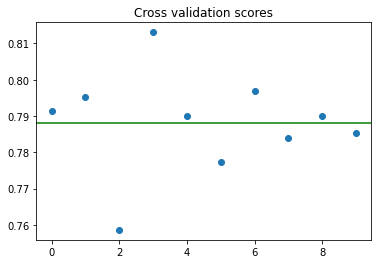

In [145]:
scores = cross_val_score(estimator=pipe_log,
                        X=Xtr_fin,
                        y=ytr_fin,
                        cv=10, 
                        n_jobs=1,
                        scoring = 'roc_auc')

print('Cross validation scores: {}'.format(scores))

plt.title('Cross validation scores')
plt.scatter(np.arange(len(scores)), scores)
plt.axhline(y=np.mean(scores), color='g') # Mean value of cross validation scores
plt.show()

However when we see the CV scores in this plot,there is quite a fluctuations based on 10 cvs. In this plot I am showing based on ROC-AUC scores, and still they are all more than 0.5.

Cross validation scores: [0.45283019 0.44393064 0.40049751 0.47820672 0.45454545 0.42758621
 0.45601852 0.44893378 0.4452381  0.43396226]


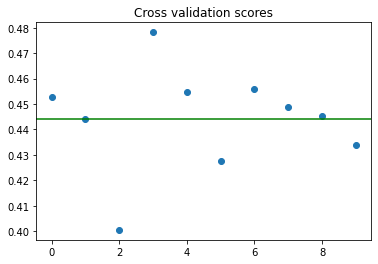

In [146]:
scores = cross_val_score(estimator=pipe_log,
                        X=Xtr_fin,
                        y=ytr_fin,
                        cv=10, 
                        n_jobs=1,
                        scoring = 'f1')

print('Cross validation scores: {}'.format(scores))

plt.title('Cross validation scores')
plt.scatter(np.arange(len(scores)), scores)
plt.axhline(y=np.mean(scores), color='g') # Mean value of cross validation scores
plt.show()

Here I showed the CV scores based on F1 score --  most of them are above 0.40, which is quite good. But the scores are still fluctuating, indicating that actually there is still a room for improvement for our model.

In [149]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_log,
                                                       X=logitsig2,
                                                       y=target_try2,
                                                       train_sizes=np.linspace(0.5, 1.0, 5), #generate 5 macem train size
                                                       cv=10)

print(train_scores)
# Mean value of accuracy against training data
train_mean = np.mean(train_scores, axis=1)
print('train mean')
print(train_mean)
print("train sizes")
print(train_sizes)

# Standard deviation of training accuracy per number of training samples
print('train std')
train_std = np.std(train_scores, axis=1)
print(train_std)

# Same as above for test data

print('test mean')
test_mean = np.mean(test_scores, axis=1)
print(test_mean)

print('test std')
test_std = np.std(test_scores, axis=1)
print(test_std)

# Plot training accuracies 
plt.plot(train_sizes, train_mean, color='red', marker='o', label='Training Accuracy')
# Plot the variance of training accuracies
plt.fill_between(train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15, color='red')

# Plot for test data as training data
plt.plot(train_sizes, test_mean, color='blue', linestyle='--', marker='s', 
        label='Test Accuracy')

#fill between semacam std nya
plt.fill_between(train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='blue')

plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

KeyboardInterrupt: ignored

So far I have explored the model using all significant features -- it also helped me to know better which features are more important among the others (it's more for descriptive). 

But now supposed I want to predict just based on the characteristic of the customers : age, job, marital status, and education -- I did not put the housing and loan, because none of the them are significant in our earlier significance test. 

We will see whether our model earlier can help predict or at least give a probability whether customers with certain characteristic will be in our Target Yes or not.

Now we will be back to our original dataset, and only taking the features I mentioned above.

In [0]:
# Logistic Regression

solver = ['saga']
max_iter = [1000, 1500, 2000, 3000]
penalty = ['l1', 'l2']
class_weight = [None, 'balanced']
C = [0.01, 0.1, 1, 10,]

log_reg_param = {'solver': solver,
                 'max_iter': max_iter,
                 'penalty': penalty,
                 'class_weight': class_weight,
                 'C': C}

In [172]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [0]:
bank_fin1 = bank[['job', 'marital', 'education', 'contact', 'age']]

In [183]:
bank_fin1.head()

,job,marital,education,contact,age
0,housemaid,married,basic.4y,telephone,56
1,services,married,high.school,telephone,57
2,services,married,high.school,telephone,37
3,admin.,married,basic.6y,telephone,40
4,services,married,high.school,telephone,56


In [0]:
fin1 = pd.get_dummies(bank_fin1, columns = bank_fin1.select_dtypes(exclude = 'number').columns)

In [185]:
fin1.head()

,age,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,contact_cellular,contact_telephone
0,56,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
1,57,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
2,37,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,40,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
4,56,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


In [0]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(fin1, target, test_size = 0.3, random_state = 101)

In [187]:
log_reg.fit(X_train2, y_train2)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
X_train2scale = scaler.fit_transform(X_train2)
X_test2scale = scaler.transform(X_test2)

In [191]:
log_reg.fit(X_train2scale, y_train2)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [192]:
f1_score(y_train2, log_reg.predict(X_train2scale))

0.2737882577110873

In [193]:
f1_score(y_test2, log_reg.predict(X_test2scale))

0.2604960509907164

In [194]:
print(classification_report(y_test2, log_reg.predict(X_test2scale)))

              precision    recall  f1-score   support

           0       0.93      0.55      0.69     10978
           1       0.16      0.68      0.26      1379

    accuracy                           0.57     12357
   macro avg       0.55      0.62      0.48     12357
weighted avg       0.85      0.57      0.65     12357



In [195]:
print(confusion_matrix(y_test2, log_reg.predict(X_test2scale)))

[[6080 4898]
 [ 439  940]]


Our model surprisingly can predict more True positive than False Negative -- but False Positives is also increasing. Looking at full picture of our confusion matrix, it's actually indicating that our model is quite bad (probably because of lack of features) -- Almost 50% of Target No was miclassified (this can cost resources for bank).